<a href="https://colab.research.google.com/github/Ana-PPS/data-and-analytcs/blob/MVP_II/MVP_b_SprintII_AnaPaulaSalgado_entrega.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint II: Machine Learning & Analytics**
**Parte b**

Aluna: Ana Paula Pinheiro Salgado

Julho/2023

## Seção I: Introdução
**Classificador de imagens multiclasse - Animais**

**Contexto:** Temos um conjunto de imagens que representam 4 categorias de animais: vaca, galinha, cavalo e elefante. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma imagem dentre essas categorias.

**Estrutura:** O notebook encontra-se dividido da seguinte forma:

- Importação das bibliotecas
- Acesso e tratamento dos dados que serão a entrada do modelo de deep learning
- Configuração do modelo de deep learning usando uma rede neural convolucional simples com Keras
- Treinamento do modelo de deep learning
- Execução do modelo de deep learning treinado
- Avaliação do modelo de deep learning
- Exportação do modelo de deep learning
- Teste do modelo exportado

**Dataset:** A partir do dataset original, baixado do Kaggle (https://www.kaggle.com/datasets/alessiocorrado99/animals10), foram selecionadas apenas 4 pastas de imagens de forma a otimizar o tempo de execução do MVP.

### Importando as bibliotecas necessárias para executar o notebook
(Serão utilizadas as bibliotecas pandas e numpy, para a manipulação dos dados; matplotlib, para geração de gráficos; os, para manipulação de pastas e diretórios e bibliotecas voltadas para Machine e Deep Learning, tais como Keras, Tensor Flow e Scikit-Learn)


In [ ]:
# para usar o Google Drive
!pip install -q gdown
import gdown
from google.colab import drive

#para acessar e manipular arquivos, diretórios e estrutra de dados
import os
import shutil
from zipfile import ZipFile
import pandas as pd

# cálculos numéricos e operações matemáticas e trabalhar com números aleatórios
import numpy as np
import math
import random

# bibliotecas do keras para pré-processamento, modelos convolucionais e otimizadores dos modelos
!pip install -q tensorflow
!pip install -q keras
from tensorflow import keras
from keras.optimizers import Adam
from keras.preprocessing import image
#from keras.layers.experimental import preprocessing
from keras.layers import BatchNormalization
from keras import layers,models,Model
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.preprocessing import image as keras_image
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

# sckit-learn para pré-processamento e uso de métricas em machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import sklearn.metrics as skm

# plotagem de gráficos, visualizações e imagens
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from skimage.io import imread
from skimage.transform import resize

# iterações
import itertools

# para uso de data e hora
from datetime import datetime

##Seção II: Acessando e tratando os dados que serão a entrada do modelo de deep learning

In [ ]:
# Baixando a pasta compactada para o notebook
file_id = "1bg_JhbuWv2lCCDyrfGI2yr5dROxbijYQ"

folder_path = f"https://drive.google.com/uc?id={file_id}"
output = "4animais.zip"
gdown.download(folder_path, output)

In [ ]:
# Descompactando o arquivo
with ZipFile('4animais.zip', 'r') as zip_object:
  zip_object.extractall()

In [ ]:
# Reunindo todos os arquivos em uma pasta para transformar em um dataset

path = "/content/"

classes = ['vaca', 'galinha', 'elefante', 'cavalo']

foldernames = os.listdir(path)

data = {"images": [], "animal": []}

for folder in classes:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["images"].append(fpath)
        data["animal"].append(folder)


df = pd.DataFrame(data)

In [ ]:
print(df.head)
print(df.shape)

In [ ]:
#Resumo do dataset criado

print("Tamanho do dataset: ", df.shape)
print("_______________________________________")
print("Valores null: ")
print(df.isnull().sum())
print("_______________________________________")
print("Valores únicos: ")
print(df.nunique())

print("_______________________________________")
print("Qnt de imagens por categoria : ")
print(df.animal.value_counts())

print("_______________________________________")
print("Informação do dataset: ")
print(df.info())

In [ ]:
#Visualizando algumas imagens do conjunto de dados
fig = plt.gcf()
fig.set_size_inches(3*4, 3*4)
for i, row in df.sample(n=10).reset_index().iterrows():
    plt.subplot(2,5,i+1)
    image_path = row['images']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["animal"])
    plt.axis('off')
plt.show()

In [ ]:
# Separação do dataframe em treino, teste e validação
df_train, Temp_df = train_test_split(df, train_size=0.7, random_state=13, shuffle=True)
df_test, df_val = train_test_split(Temp_df, test_size=0.6, random_state=30, shuffle=True)

In [ ]:
#Resumo da separação do conjunto de dados
print("#########Train##############")
print(df_train.head())
print(df_train.shape)
print("#########Test###############")
print(df_test.head())
print(df_test.shape)
print("#########Validação###############")
print(df_val.head())
print(df_val.shape)

###  Preparação dos dados

`ImageDataGenerator` é uma classe utilitária fornecida pelo TensorFlow para aumentar e pré-processar dados de imagens. É comumente usada em tarefas de deep learning, especialmente para classificação de imagens, para gerar imagens aumentadas (data augmentation) sob demanda durante o treinamento do modelo.

O Data Augmentation aplica transformações aleatórias nas imagens existentes, o que ajuda a evitar overfitting e torna o modelo mais robusto, expondo-o a uma variedade maior de variações nas imagens.


In [ ]:
# Definindo o tamanho do batch, a dimensão das imagens e a quantidade de épocas
batch_size = 32
img_height = 224
img_width = 224
num_classes = 4
epochs = 30

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

val_datagen=ImageDataGenerator(rescale=1./255)

test_datagen=ImageDataGenerator(rescale=1./255)


train_generator=train_datagen.flow_from_dataframe(
    dataframe=df_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    seed = 13,
    shuffle=False
    )

val_generator=val_datagen.flow_from_dataframe(
    dataframe=df_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False
    )

test_generator=test_datagen.flow_from_dataframe(
    dataframe = df_test,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    x_col='images',
    y_col='animal',
    color_mode ='rgb',
    shuffle=False)

## Seção III: Configuração do Modelo de Deep Learning

### Configuração de um modelo de deep learning usando uma rede neural convolucional (CNN) simples com a biblioteca Keras

Aqui foi especificada uma camada convolucional 2D que possui 32 filtros(depois 64, 128 e 256) e função de ativação `ReLU`. Na sequência é adicionada uma camada `softmax` com a mesma função de ativação.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Resumindo o modelo que será utilizado
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

### Treinamento do modelo de deep learning

#### Compilação do modelo Keras com as configurações do treinamento.

`optimizer='adam'`: especifica o otimizador a ser usado durante o treinamento.

`loss='categorical_crossentropy'`: especifica a função de perda a ser usada durante o treinamento. Para problemas de classificação multiclasse, onde a variável alvo tem mais de duas categorias, a perda categórica de entropia cruzada é freqüentemente empregada.

`metrics=['accuracy']`: especifica as métricas de avaliação a serem usadas durante o treinamento e o teste.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/30
198/198 [==============================] - 111s 465ms/step - loss: 1.3050 - accuracy: 0.4121 - val_loss: 1.1121 - val_accuracy: 0.5172
Epoch 2/30
198/198 [==============================] - 92s 464ms/step - loss: 1.0081 - accuracy: 0.5757 - val_loss: 1.0225 - val_accuracy: 0.6107
Epoch 3/30
198/198 [==============================] - 88s 446ms/step - loss: 0.9104 - accuracy: 0.6317 - val_loss: 0.8918 - val_accuracy: 0.6415
Epoch 4/30
198/198 [==============================] - 90s 454ms/step - loss: 0.8196 - accuracy: 0.6660 - val_loss: 0.8052 - val_accuracy: 0.6980
Epoch 5/30
198/198 [==============================] - 90s 456ms/step - loss: 0.7496 - accuracy: 0.6938 - val_loss: 0.7195 - val_accuracy: 0.7214
Epoch 6/30
198/198 [==============================] - 89s 449ms/step - loss: 0.7143 - accuracy: 0.7118 - val_loss: 0.6994 - val_accuracy: 0.7134
Epoch 7/30
198/198 [==============================] - 98s 498ms/step - loss: 0.6602 - accuracy: 0.7409 - val_loss: 0.7713 - val_a

#### Visualização de métricas da avaliação do modelo treinado

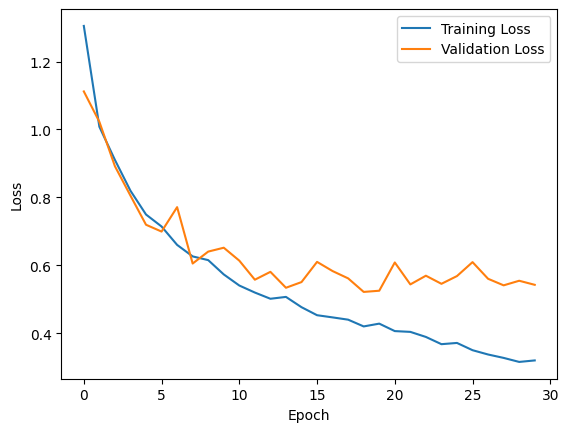

In [ ]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

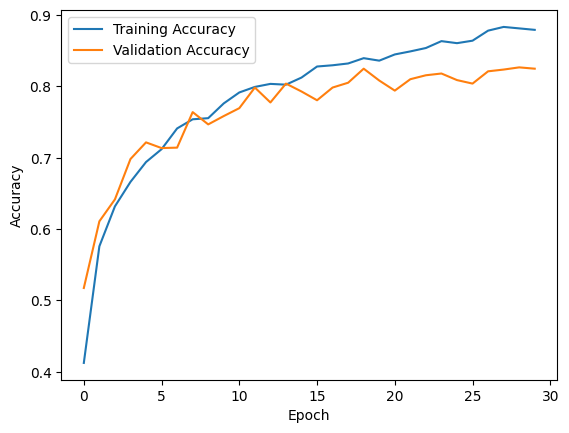

In [ ]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

O modelo na primeira arquitetura parece começar a apresentar overfitting, dado que a acurácia tende a um resultado bem superior no conjunto de treinamento, com tendência inversa no conjunto de validação. Começando a apresentar divergência de resultados a partir da 10ª época.

Para tentar melhorar a generalização e reduzir overfitting, será aplicado algumas camadas de dropout e uma camada Flatten para transformar os dados em um único vetor, preparando-os para camada Densa posterior.

### Otimização do 1º modelo

Nesta versão foi inserida uma camada de Dropout para tentar melhorar a generalização e reduzir overfitting, além de mais camadas para aumentar a complexidade visando melhorar a capacidade de aprendizado do modelo.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),  # Aumentar a complexidade com mais unidades
    keras.layers.Dropout(0.2),  # Incluir mais uma camada de dropout
    keras.layers.Dense(128, activation='relu'),  # Adicionar outra camada Dense
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Resumindo o modelo que será utilizado
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 55, 55, 128)      

### Treinamento com o modelo otimizado

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/30
198/198 [==============================] - 105s 509ms/step - loss: 1.2533 - accuracy: 0.4349 - val_loss: 1.0590 - val_accuracy: 0.5480
Epoch 2/30
198/198 [==============================] - 102s 513ms/step - loss: 1.0077 - accuracy: 0.5709 - val_loss: 0.8794 - val_accuracy: 0.6015
Epoch 3/30
198/198 [==============================] - 94s 474ms/step - loss: 0.8839 - accuracy: 0.6255 - val_loss: 0.7767 - val_accuracy: 0.6876
Epoch 4/30
198/198 [==============================] - 94s 476ms/step - loss: 0.8115 - accuracy: 0.6620 - val_loss: 0.7682 - val_accuracy: 0.6863
Epoch 5/30
198/198 [==============================] - 93s 470ms/step - loss: 0.7756 - accuracy: 0.6864 - val_loss: 0.7053 - val_accuracy: 0.7017
Epoch 6/30
198/198 [==============================] - 93s 467ms/step - loss: 0.7293 - accuracy: 0.7028 - val_loss: 0.6889 - val_accuracy: 0.7251
Epoch 7/30
198/198 [==============================] - 92s 464ms/step - loss: 0.6997 - accuracy: 0.7182 - val_loss: 0.6762 - val_

#### Visualização de métricas da avaliação do modelo treinado (modelo otimizado)

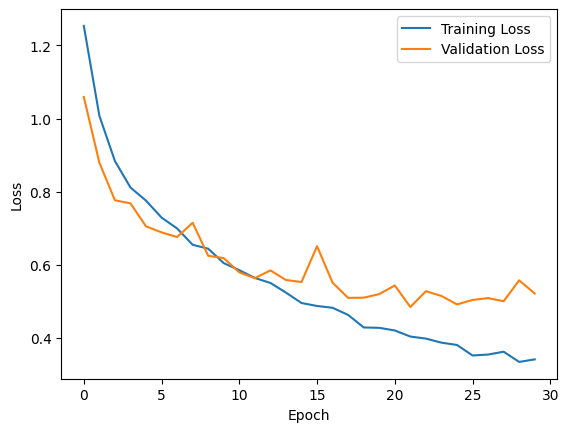

In [ ]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

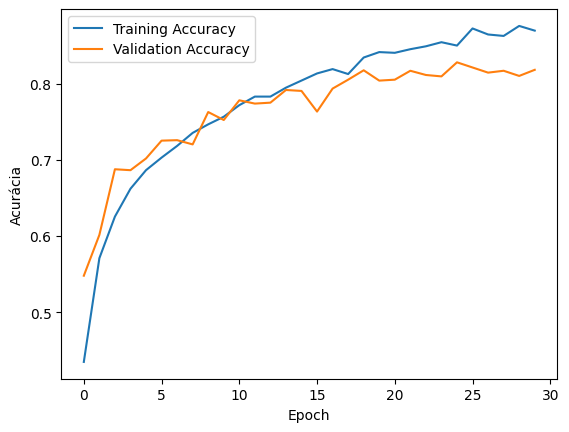

In [ ]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## 5. Execução do modelo de deep learning treinado nas imagens de teste

In [ ]:
count_images = 0
class_names = ['vaca', 'galinha', 'elefante', 'cavalo']
y_pred = list()
y_true = list()
limite_imagens = 10

In [ ]:
from keras.preprocessing.image import img_to_array

for img_path, label in zip(df_test['images'], df_test['animal']):
    _, file_extension = os.path.splitext(img_path)
    if file_extension.lower() in ['.jpeg', '.jpg', '.png']:
        count_images += 1

        split_path = img_path.split('/')
        label = split_path[2]
        y_true.append(label)

        img = Image.open(img_path).resize((300, 300))
        display(img)

        img = keras_image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x.astype('float32') / 255.0

        # Previsão
        prediction = model.predict(x)

        # Printando as saídas do modelo
        predicted_class = np.argmax(prediction[0])
        probability = prediction[0][predicted_class]
        y_pred.append(class_names[predicted_class])
        print("Label:", label)
        print("Previsão:", class_names[predicted_class])
        print("Probabilidade:", probability)
        print("\n")

ImportError: ignored

In [ ]:
count_images = 0
class_names = ['vaca', 'galinha', 'elefante', 'cavalo']
y_pred = list()
y_true = list()
limite_imagens = 10

for img_path, label in zip(df_test['images'], df_test['animal']):
    _, file_extension = os.path.splitext(img_path)
    if file_extension.lower() in ['.jpeg', '.jpg', '.png']:
        count_images += 1
        if count_images > limite_imagens:
            break

        split_path = img_path.split('/')
        label = split_path[2]
        y_true.append(label)

        img = Image.open(img_path).resize((300, 300))
        display(img)

        img = image.load_img(img_path, target_size=(img_height, img_width))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x.astype('float32') / 255.0

        # Previsão
        prediction = model.predict(x)

        # Printando as saídas do modelo
        predicted_class = np.argmax(prediction[0])
        probability = prediction[0][predicted_class]
        y_pred.append(class_names[predicted_class])
        print("Label:", label)
        print("Previsão:", class_names[predicted_class])
        print("Probabilidade:", probability)
        print("\n")

        if count_images > limite_imagens:
            break

AttributeError: ignored

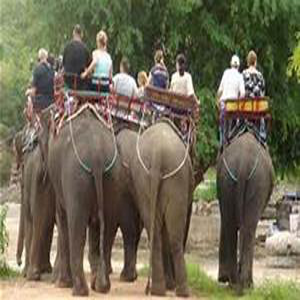

AttributeError: ignored

In [ ]:
count_images = 0
class_names = ['vaca', 'galinha', 'elefante', 'cavalo']
y_pred = list()
y_true = list()

# Percorrendo a pasta onde estão salvas as imagens de teste

for img_path, label in zip(df_test['images'], df_test['animal']):

    if img_path.endswith('.jpeg') or img_path.endswith('.jpg') or img_path.endswith('.png'):

            split_path = img_path.split('/')
            label = split_path[2]
            y_true.append(label)

            display(Image.open(img_path).resize((300, 300)))
            img = image.load_img(img_path, target_size=(img_height, img_width))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x.astype('float32') / 255.0

            # Previsão
            prediction = model.predict(x)

            # Printando as saídas do modelo
            predicted_class = np.argmax(prediction[0])
            probability = prediction[0][predicted_class]
            y_pred.append(class_names[predicted_class])
            print("Rótulo Real:", label)
            print("Rótulo Previsto:", class_names[predicted_class])
            print("Probabilidade:", probability)
            print("\n")


#### Visualização de métricas da avaliação do modelo

In [ ]:
# Calculando as métricas do modelo aplicado as imagens de teste
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

In [ ]:
# Definindo função para plotar a matriz de confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')

A matriz de confusão identifica onde o modelo de deep learning acertou e errou na classificação das imagens de teste

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=['vaca', 'cavalo', 'galinha', 'elefaante'],
                      normalize= False,
                      title='Matriz real x predição')

## Seção V: Exportação do modelo de deep learning para posterior uso

Salvando o modelo de deep learning que foi treinado

In [ ]:
# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

path_model = 'content/trained_models'

name_model = 'trained_model_' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (path_model, name_model))
print("Modelo salvo com o nome: ", name_model)

## Seção VI: Teste do modelo exportado

Carregando o modelo salvo

In [ ]:
loaded_model = keras.models.load_model("%s/%s" % (path_model, name_model))
print("Modelo %s carregado com sucesso" % (name_model))

Executando o modelo exportado para acompanhar as classificações de cada uma das imagens de teste

In [ ]:
count_images = 0
class_names = ['vaca', 'galinha', 'elefante', 'cavalo']
y_pred = list()
y_true = list()

# Percorrendo a pasta onde estão salvas as imagens de teste

for img_path, label in zip(df_test['images'], df_test['animal']):

    if img_path.endswith('.jpeg') or img_path.endswith('.jpg') or img_path.endswith('.png'):

            split_path = img_path.split('/')
            label = split_path[2]
            y_true.append(label)

            display(Image.open(img_path).resize((300, 300)))
            img = image.load_img(img_path, target_size=(img_height, img_width))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = x.astype('float32') / 255.0

            # Previsão
            prediction = model.predict(x)

            # Printando as saídas do modelo
            predicted_class = np.argmax(prediction[0])
            probability = prediction[0][predicted_class]
            y_pred.append(class_names[predicted_class])
            print("Rótulo Real:", label)
            print("Rótulo Previsto:", class_names[predicted_class])
            print("Probabilidade:", probability)
            print("\n")
